In [ ]:
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np
import csv

np.set_printoptions(precision=10)
import sys
import random
from random import seed
from random import randint
from sklearn.metrics import accuracy_score
from bs4 import BeautifulSoup

from random import randrange

pd.option_context('display.max_rows', None, 'display.max_columns', None)  # more options can be specified also
np.set_printoptions(threshold=sys.maxsize)
seed(1)

np.set_printoptions(precision=10, )
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)
%precision 10

%precision 10
!cp -r /content/drive/MyDrive/10601_DataSets /content

''' Assignment Data description: 
  A one line per example format consisting of the label 0 or 1 in the first column followed by
  all the words in the movie review (with none of the line breaks) in the second column.

  Each data point consists of a label (0 for negatives and 1 for positives) and a attribute 
  (a set of words as a whole). 
  
  In the attribute, words are separated using white-space (punctuations are also separated with whitespace).
  All characters are lowercased. No fancy pre-processing on the plain text is needed.

  The data files are in tab-separated-value (.tsv) format. This is identical to a comma-separated-value
  (.csv) format except that instead of separating columns with commas, we separate them with a tab character,
  \t. 
  Each row is ended by a Unix style line ending, \n. The first column always contains the label and
  the second column the set of words: label\tword1 word2 word3 ... wordN\n.

  A dictionary file (dict.txt) to limit the vocabulary to be considered in this assignments. 
  Actually, this dictionary is constructed from the training data. 
  
  Examples of the dictionary content are as follows, where the second column is the index of
  the word. Column one and column two are separated with white-space. 

  Each line in dict.txt has the format: word index\n.

'''

' Assignment Data description: \n  A one line per example format consisting of the label 0 or 1 in the first column followed by\n  all the words in the movie review (with none of the line breaks) in the second column.\n\n  Each data point consists of a label (0 for negatives and 1 for positives) and a attribute \n  (a set of words as a whole). \n  \n  In the attribute, words are separated using white-space (punctuations are also separated with whitespace).\n  All characters are lowercased. No fancy pre-processing on the plain text is needed.\n\n  The data files are in tab-separated-value (.tsv) format. This is identical to a comma-separated-value\n  (.csv) format except that instead of separating columns with commas, we separate them with a tab character,\n  \t. \n  Each row is ended by a Unix style line ending, \n. The first column always contains the label and\n  the second column the set of words: label\tword1 word2 word3 ... wordN\n.\n\n  A dictionary file (dict.txt) to limit the v

In [ ]:
col_names = ["Label", "words"]
large_train = pd.read_csv('/content/10601_DataSets/HW4/largedata/train_data.tsv', names=col_names, sep= '\t', header=None)
large_valid = pd.read_csv('/content/10601_DataSets/HW4/largedata/valid_data.tsv', names=col_names, sep= '\t', header=None)
large_test = pd.read_csv('/content/10601_DataSets/HW4/largedata/test_data.tsv', names=col_names, sep= '\t', header=None)

print("Training data shape: ", large_train.shape)
print("validation data shape: ", large_valid.shape)
print("test data shape: ", large_test.shape)

Training data shape:  (1200, 2)
validation data shape:  (200, 2)
test data shape:  (400, 2)


In [ ]:
large_train['words'][0]

'films adapted from comic books have had plenty of success , whether they\'re about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there\'s never really been a comic book like from hell before . for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid \'80s with a 12-part series called the watchmen . to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd . the book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes . in other words , don\'t dismiss this film because of its source . if you can get past the whole comic book thing , you might find another stumbling block in from hell\'s directors , albert and allen hughes . getting the hughes brothers to direct this seems almost as 

In [ ]:
col_names = ['word', 'index']
dict_DF = pd.read_csv('/content/10601_DataSets/HW4/dict.txt', names=col_names, sep= ' ', header=None)
dict_DF.head()
print("Dictionary shape: ", dict_DF.shape)
BOW = dict_DF.set_index('word')['index'].to_dict()
parameter_size = dict_DF.shape[0] + 1

Dictionary shape:  (39176, 2)


In [ ]:
def modified_sigmoid(w_sig, x_sig):
  '''
  Compute sigmoid(w.T* x) equation and return the result. Note that
  the bias term is embedded inside the w vector
  '''
  return 1 / (1 + np.exp(-1 * dot_product(w_sig.T, x_sig)))

def dot_product(param, tr_exmp):
  '''
    tr_exmp: list of (index:value) pairs, where value is always 1.
    param: a vector with dimension ~ 40000
    This function manually calculates the dot product of finite number 
    of parameters only 
  '''
  tmp = 0
  for pair in tr_exmp:
    index = int(pair.split(':')[0])
    tmp += param[0][index]

  return tmp

def SGD_update(theta_tr, x_train, y_train, learning_rate):
  '''
    This function updates the parameters for logistic regression binary
    classification. 

    The update rule: 
    Theta_j = Theta_j + eta * x(i)_j * [y(i) - sigmoid(Theta.T * x(i) * exp(Theta.T * x(i)))]
    (1 x 1) = (1 x 1) + eta * (1 x 1) * [(1 x 1) - sigmoid(1 x 1) * exp(1 x 1)]

    For vectorization: 
    Theta = Theta + eta * x(i) * [y(i) - sigmoid(Theta.T * x(i) * exp(Theta.T * x(i)))]
    ((M + 1) x 1) = ((M + 1) x 1) + eta * ((M + 1) x 1) * [(1 x 1) -sigmoid(1 x 1) * exp(1 x 1)]

    Theta: (M + 1) x 1 parameters for the model
    X: Training data with shape (N x (M + 1))
    y: Training labels with shape (n x 1)

    Input: 
    x_train: it is the training example we use to update the parameters, It's a list of indexes
    y_train: The corresponding label
    theta_tr: Theta matrix to update its parameters

    Return: Theta matrix ((M + 1) x 1)
  '''
  update_term = -1 * learning_rate * (modified_sigmoid(theta_tr, x_train) - y_train)

  for pair in x_train:
    index = int(pair.split(':')[0])
    theta_tr[index] = theta_tr[index] + update_term

  return theta_tr

In [ ]:
def get_random(exec_dict):
  
  random_num = random.randint(0, 1199)

  # Check to see if we already chosen this random number
  while exec_dict.get(random_num, -1) != -1:
    random_num = random.randint(0, 1199)

  return random_num

def calculate_cross_entropy_loss(df_dt, theta_tmp):

  '''
    This function calculates the cross entropy error in the form of:
    E(w) = -ln(p(t|w)) = - Sum from i = 1 to N {tn * ln(yn) + (1 - tn) * ln(1- yn)}
  '''
  tmp = 0

  for index, row in df_dt.iterrows():

    # Get target value
    target = int(row['Label'])
    
    # Get sigmoid term
    predict = modified_sigmoid(theta_tmp, row['features'].split(', '))

    # Calculate the equation
    if np.log(predict) == 0:
      tmp += (0)
    else: 
      tmp += (target * np.log(predict) + (1 - target) * np.log(1 - predict))
  
  return -1 * tmp / df_dt.shape[0]

In [ ]:
def train_logistic_regression(df_data_train, df_data_valid, epochs, choice_shuffle, learning_r):

  # Initialize parameters to be zeros
  theta = np.zeros([parameter_size, 1])

  CrossEntropyList = []

  if choice_shuffle == 'shuffle':
    execlude_dict = {}
    for epoch in range(0, epochs):
      
      execlude_dict = {}
      
      # for index, row in df_data_train.iterrows():
      for i in range(0, df_data_train.shape[0]):
        
        # # Get a random training example
        tr_random = get_random(execlude_dict)

        # # Execlude this training example from being chosen again
        execlude_dict[tr_random] = 1

        # take i to be number of example to use, this SGD is without shuffling
        # Send list of (index: value) pair as training example
        theta = SGD_update(theta, df_data_train['features'][tr_random].split(', '), int(df_data_train['Label'][tr_random]), learning_r)
        
      CrossEntropyList.append(calculate_cross_entropy_loss(df_data_valid, theta))

  else:
    for epoch in range(0, epochs):
      for index, row in df_data_train.iterrows():
        # take i to be number of example to use, this SGD is without shuffling
        # Send list of (index: value) pair as training example
        theta = SGD_update(theta, row['features'].split(', '), int(row['Label']), learning_r)
      CrossEntropyList.append(calculate_cross_entropy_loss(df_data_valid, theta))

  return theta, CrossEntropyList

def test_logistic_regression(df_data, theta_test, name):
  
  predict = []

  for index, row in df_data.iterrows():
    tmp = dot_product(theta_test.T, row['features'].split(', '))
    predict.append(1 / (1 + np.exp(-1 * tmp)))

  y_pred = np.array(predict)

  # Decision boundary theorem where prob >= 0.5 is class 1
  ones_class_indeces = y_pred >= 0.5 
  zeros_class_indeces = y_pred < 0.5 
  y_pred[ones_class_indeces] = 1
  y_pred[zeros_class_indeces] = 0

  print(name, accuracy_score(np.array(df_data['Label']), np.array(np.squeeze(y_pred))))

In [ ]:
# Feature extraction stage
def feature_extraction(df_data, bag_of_words, feature_flag, file_name, trimming_threshold):
  '''
  This function converts raw data into formatted data. Transfer the whole review text into
  a feature vector using some feature extraction methods. Store the formatted data sets in .tsv format

  must return a sparse representation of the data using the label-index-value format
  {label index[word1]: value1  index[word2]: value2...\n}

  feature extraction function writes three output .tsv files converting original data to formatted data
  on <formatted train out>, <formatted valid out>, and <formatted test out>. Each should contain the
  formatted presentation for each example printed on a new line. Use \n to create a new line. 
  
  The format for each line should exactly match:
  label\tindex[word1]:value1\tindex[word2]:value2\t...index[wordM]:valueM\n
  
  Where above, the first column is label, and the rest are ”index[word]:value” feature elements. 
  
  index[word] is the index of the word in the dictionary, and value is the value of this feature 
  (in this assignment, the value is one or zero).

  <feature flag> that specifies one of two types of feature extraction structures that should 
  be used by the logistic regression model.
  '''
  # This line is the whole format written in tsv file
  line_formatted = ""

  # Use this dictionary to store words' repeatitions
  tmp_dict = {}
  
  # Iterate over all reviews
  for index, row in df_data.iterrows():

    # Get all review words
    tmp_dict = Get_review_words(row['words'])

    # Get line format needed 
    line_formatted += Get_Line_Format(tmp_dict, row['Label'], bag_of_words, 
                                     feature_flag, trimming_threshold)

  with open(file_name + '.tsv', 'w') as tsvfile:
    tsvfile.write(line_formatted)

In [ ]:
def Get_review_words(review_exmp):
  '''
    This function returns a dictionary of all words and their number 
    of occurances in the review.
  '''
  review_dict = {}

  for word in review_exmp.split(' '):
    # Get this word's freuqency in this example
    review_dict[word] = review_dict.get(word, 0) + 1

  return review_dict

def Get_Line_Format(rev_dict, rev_label, BgOfWd, flag, threshold):
  '''
    This function returns the required format for feature extraction
    function. 
  '''
  line_form = ""

  # Start formatting the line
  line_form += str(rev_label)+ '\t'
  tmp = 0

  if flag == 1:
    for key in rev_dict:
      # For each word get the index from the bag of words
      word_index = BgOfWd.get(key, -1)

      # Check if word is in BOW; if exists then get the line format needed
      if word_index != -1:
        if tmp == 0:
          tmp = 1
          line_form += str(word_index) + ':1'
        else:
          line_form += ', ' + str(word_index) + ':1'

    line_form += '\n'
  
  elif flag == 2:

    for key in rev_dict:
      # For each word get the index from the bag of words
      word_index = BgOfWd.get(key, -1)

      # Check if word is in BOW; if exists then get the line format needed
      if word_index != -1 and rev_dict[key] < threshold:
        if tmp == 0:
          tmp = 1
          line_form += str(word_index) + ':' + str(rev_dict[key])
        else:
          line_form += ', ' + str(word_index) + ':1' 
    line_form += '\n'

  else:
    print("Wrong feature flag")

  return line_form

In [ ]:
feature_flag = 1
feature_extraction(large_valid, BOW, feature_flag, 'formatted_valid_out', 4)
feature_extraction(large_train, BOW, feature_flag, 'formatted_train_out', 4)
feature_extraction(large_test, BOW, feature_flag, 'formatted_test_out', 4)

col_names = ['Label', 'features']
large_train_Model_1 = pd.read_csv('/content/formatted_train_out.tsv', names=col_names, sep='\t', header=None)
large_valid_Model_1 = pd.read_csv('/content/formatted_valid_out.tsv', names=col_names, sep= '\t', header=None)
large_test_Model_1 = pd.read_csv('/content/formatted_test_out.tsv', names=col_names, sep= '\t', header=None)

In [ ]:
feature_flag = 2
feature_extraction(large_valid, BOW, feature_flag, 'formatted_valid_out', 4)
feature_extraction(large_train, BOW, feature_flag, 'formatted_train_out', 4)
feature_extraction(large_test, BOW, feature_flag, 'formatted_test_out', 4)

col_names = ['Label', 'features']
large_train_Model_2 = pd.read_csv('/content/formatted_train_out.tsv', names=col_names, sep='\t', header=None)
large_valid_Model_2 = pd.read_csv('/content/formatted_valid_out.tsv', names=col_names, sep= '\t', header=None)
large_test_Model_2 = pd.read_csv('/content/formatted_test_out.tsv', names=col_names, sep= '\t', header=None)

In [ ]:
def lr(lr_training_data, lr_validation_data, lr_testing_data, epochs, l_rate):
  '''
  This function implements a sentiment polarity analyzer using binary
  logistic regression. 

  The function learns the parameters of a binary logistic regression model that
  predicts a sentiment polarity (i.e. label) for the corresponding feature vector 
  of each movie review. 
  
  The function should return the labels of the training and test examples and calculate
   training and test error (percentage of incorrectly labeled reviews).
  '''
  lr_theta, c_entropy_list = train_logistic_regression(lr_training_data, lr_validation_data, epochs, 'No_shuffle', l_rate)
  test_logistic_regression(lr_testing_data, lr_theta, 'test accuracy')
  test_logistic_regression(lr_training_data, lr_theta, 'train accuracy')

  return c_entropy_list, lr_theta

In [ ]:
entropyList1, theta_model1 = lr(large_train_Model_1, large_valid_Model_1, large_test_Model_1, 60, 0.1)
entropyList2, theta_model2 = lr(large_train_Model_2, large_valid_Model_2, large_test_Model_2, 60, 0.1)

test accuracy 0.75
train accuracy 0.9275
test accuracy 0.8175
train accuracy 1.0


Text(0, 10, '0.60296')

<Figure size 432x288 with 0 Axes>

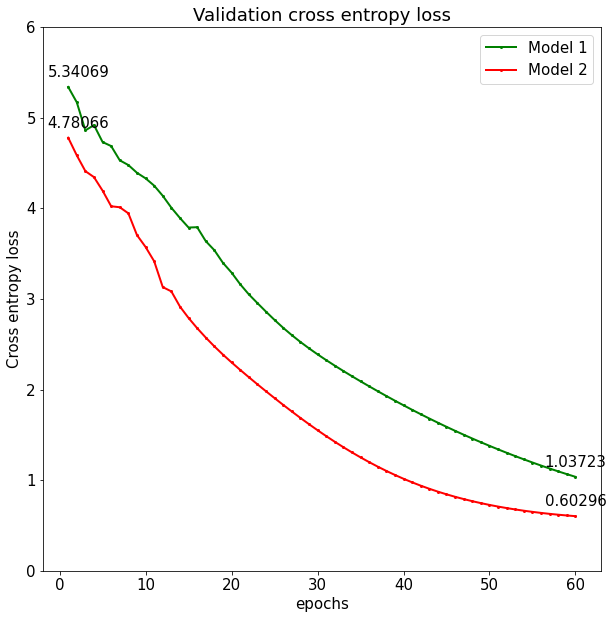

In [ ]:
ep = [i for i in range(1, 61)]

fig = plt.figure()
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 15})
plt.ylabel('Cross entropy loss')
plt.xlabel('epochs')
plt.plot(np.array(ep), np.array(entropyList1), color='green', marker='o', linestyle='solid', linewidth=2, markersize=2, label = "Model 1")
plt.plot(np.array(ep), np.array(entropyList2), color='red', marker='o', linestyle='solid', linewidth=2, markersize=2, label = "Model 2")
plt.ylim(0,6)
plt.legend()
plt.title("Validation cross entropy loss")

label = "{:.5f}".format(entropyList1[0])

plt.annotate(label, # this is the text
              (1,entropyList1[0]), # this is the point to label
              textcoords="offset points", # how to position the text
              xytext=(10,10), # distance from text to points (x,y)
              ha='center') # horizontal alignment can be left, right or center

label = "{:.5f}".format(entropyList2[0])

plt.annotate(label, # this is the text
              (1,entropyList2[0]), # this is the point to label
              textcoords="offset points", # how to position the text
              xytext=(10,10), # distance from text to points (x,y)
              ha='center') # horizontal alignment can be left, right or center

label = "{:.5f}".format(entropyList1[59])

plt.annotate(label, # this is the text
              (60,entropyList1[59]), # this is the point to label
              textcoords="offset points", # how to position the text
              xytext=(0,10), # distance from text to points (x,y)
              ha='center') # horizontal alignment can be left, right or center

label = "{:.5f}".format(entropyList2[59])

plt.annotate(label, # this is the text
              (60,entropyList2[59]), # this is the point to label
              textcoords="offset points", # how to position the text
              xytext=(0,10), # distance from text to points (x,y)
              ha='center') # horizontal alignment can be left, right or center             